# Data Science 101
### Unsupervised Learning Example

__Problem Statement__:  Given a set of VPN logins for a customer, we want to identify anomalous/suspicious logins that could be evidence of compromised credential use.  There are *many* ways to do this.  Some examples include: (1) identify common login times for a user then find logins that fall outside those times, (2) identify logins from IPs in uncommon regions of the world, (3) identify consecutive logins from locations that appear too far apart for the person to have traveled during the time between logins, etc...

For this particular set of customer VPN logs, we have the *hostname* of the machine used to log in.  This is not always the case, but it's an interesting field that we'll use here to help identify abnormal/suspicious logins.

The data consists of 139,494 samples.  We'll restrict ourselves to a single data point being a tuple: ``(user, hostname)``.

The goal is to produce a ranked list of the most interesting samples.  You can assume an end user will only look at the top of the ranked list... maybe the first 100 results.  There are multiple ways to order the list which would very likely use more information from the raw data than you have access to here with just ``(user, hostname)``.  So don't get too worried about the ordering.

The solution you come up with should be expected to work for more than just this particular dataset.  You can use any combination of analytics, rule-based filtering, and machine learning as you'd like.

We'll break the exercise into 3 phases.

1) __Data Exploration__ - examine the data, how many users, how many logins per user, how many different hostnames per user, are there patterns in the names that you want to handle?

2) __Modeling__ - develop a procedure that takes the data as input and outputs a ranked list of all or a subset of the logins where the top of the ranked list is expected to be more suspicious/anomalous

3) __Results__ - as a group we'll examine the results to see if you (and/or a Mandiant incident responder) would find them useful.  We'll also reveal known attacker logins for this customer to see if your analytic/model discovered them.

***

In [1]:
import sys
import pickle
import string
import time
from random import sample
from collections import defaultdict, Counter
import numpy as np
from sklearn import metrics, manifold
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.graph_objs import *    # https://pypi.python.org/pypi/plotly
import plotly
plotly.offline.init_notebook_mode()

import tldextract    # https://pypi.python.org/pypi/tldextract
import Levenshtein   # https://pypi.python.org/pypi/python-Levenshtein/0.12.0

#!conda install --yes --prefix {sys.prefix} -c plotly plotly
#!conda install --yes --prefix {sys.prefix} -c conda-forge python-levenshtein
#!conda install --yes --prefix {sys.prefix} -c conda-forge tldextract

In [3]:
# Load data
data = pickle.load(open("unsupervised_vpn_data.pkl", 'rb'))
N = len(data)

print('data loaded. contains {} samples.'.format(N))

data loaded. contains 139494 samples.


In [19]:
# Randomly sample some records, format is (user, hostname)
sample(data, 20)

[('danielfo', 'CMPLTSD11315WC'),
 ('michaebc', 'michaebc-mac.local'),
 ('ckrauss', 'CKRAUSS-PC5'),
 ('jelleyj', 'localhost'),
 ('tiz', 'Mnemosyne'),
 ('timothwb', 'timothwb-macbookpro-2.local'),
 ('tompkinh', 'scan-gen0003'),
 ('haydenk', 'CMPLTCD04516R3'),
 ('sarasvar', 'sarasvar-mac.local'),
 ('lash', 'lash-macbookpro.local'),
 ('azzolinc', 'CJ-HP'),
 ('toddlee', 'TODDLEE-PC4'),
 ('vsf', 'vsf-mac.local'),
 ('mccurren', 'mccurren-macbookpro55.local'),
 ('marcir', 'marcirs-MacBook-Pro.local'),
 ('lakshmid', 'CMPLTSU1400KWP'),
 ('burk', 'burk-macbookpro.local'),
 ('valerieh', 'VALERIEH-PC4'),
 ('annecs', 'CMPLTSD114081J'),
 ('ludo', 'ludo-lt4')]

In [20]:
#create sets of each
users = set([user for (user, hostname) in data])
hostnames = set([hostname for (user, hostname) in data])

In [21]:
# {user: count}
user_cnt = defaultdict(int)
for (user, hostname) in data:
    user_cnt[user] += 1

print('number of unique users = {}'.format(len(user_cnt)))

number of unique users = 11478


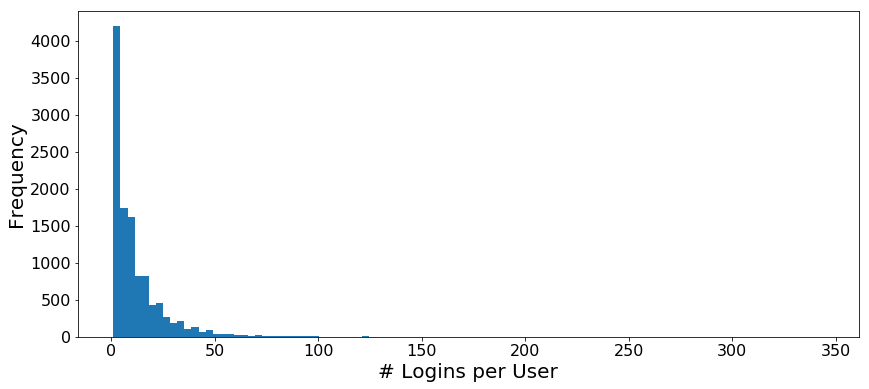

In [22]:
# Examine distribution of logins per user
plt.figure(figsize=(14, 6))
plt.hist(user_cnt.values(), bins=100)
plt.xlabel('# Logins per User', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [23]:
# Most common users
sorted(user_cnt.items(), key=lambda x: -x[1])[:10]

[('brindae', 344),
 ('lee9', 277),
 ('wendys', 214),
 ('anandm2', 212),
 ('ordwaya', 211),
 ('jonm', 203),
 ('reesem', 184),
 ('ablanc', 179),
 ('pearsonj', 176),
 ('ssteve', 168)]

In [24]:
# Most uncommon users
sorted(user_cnt.items(), key=lambda x: x[1])[:10]

[('aangrish', 1),
 ('aard', 1),
 ('abbottd', 1),
 ('abchan', 1),
 ('abdulba', 1),
 ('abdulhur', 1),
 ('abelm1', 1),
 ('aberl', 1),
 ('ablacut', 1),
 ('abramsh', 1)]

In [25]:
# Number of users with only a small number of logins
for i in range(5):
    print('# of users with {} login = {}'.format(i+1, len([1 for cnt in user_cnt.values() if cnt == i+1])))

# of users with 1 login = 1521
# of users with 2 login = 1042
# of users with 3 login = 889
# of users with 4 login = 746
# of users with 5 login = 630


In [26]:
# {(user, hostname): count}
user_host_cnt = defaultdict(int)
for tup in data:
    user_host_cnt[tup] += 1

print('number of unique (user, hostname) tuples = {}'.format(len(user_host_cnt)))

number of unique (user, hostname) tuples = 18445


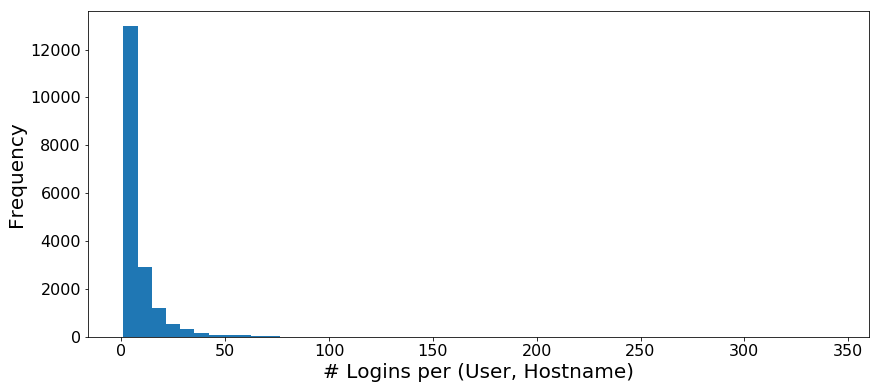

In [27]:
# Examine distribution of logins per (user, hostname)
plt.figure(figsize=(14, 6))
plt.hist(user_host_cnt.values(), bins=50)
plt.xlabel('# Logins per (User, Hostname)', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [28]:
# {user: {hostname: count}}
user_host_dict = {}
for (user, hostname) in data:
    if user not in user_host_dict:
        user_host_dict[user] = defaultdict(int)
    user_host_dict[user][hostname] += 1

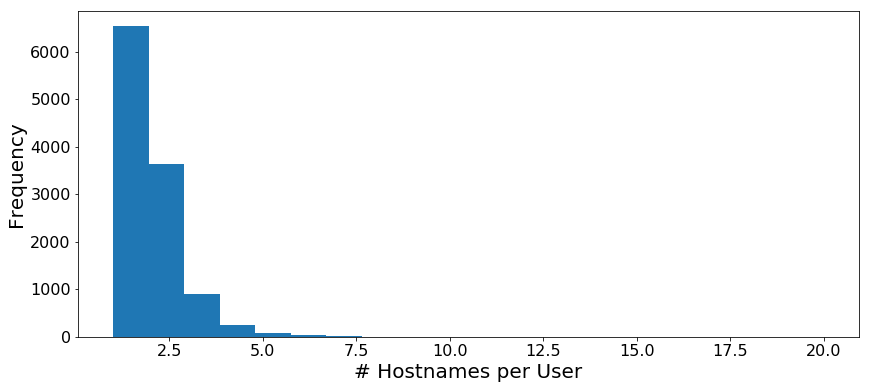

In [29]:
# Number of different hostnames per user
user_num_hosts = {user:len(d) for user, d in user_host_dict.items()}

plt.figure(figsize=(14, 6))
plt.hist(user_num_hosts.values(), bins=20)
plt.xlabel('# Hostnames per User', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [30]:
# Users with the most different unique hostnames
sorted(user_num_hosts.items(), key=lambda x: -x[1])[:10]

[('debrasea', 20),
 ('meng2', 18),
 ('michellf', 17),
 ('patricdb', 14),
 ('michelsm', 12),
 ('akaufman', 10),
 ('yuk3', 10),
 ('blastic', 9),
 ('rwyrsch', 9),
 ('shannoec', 9)]

In [31]:
# Look at different {hostname: count} for a particular user
user_host_dict['debrasea']
#user_host_dict['meng2']
#user_host_dict['michellf']
#user_host_dict['patricdb']
#user_host_dict['michelsm']
#user_host_dict['akaufman']
#user_host_dict['yuk3']

defaultdict(int,
            {'105.sub-75-208-101.zlimj.com': 1,
             '115.sub-75-210-30.zlimj.com': 1,
             '118.sub-75-210-196.zlimj.com': 1,
             '126.sub-75-210-109.zlimj.com': 1,
             '130.sub-75-210-196.zlimj.com': 1,
             '139.sub-75-208-84.zlimj.com': 1,
             '170.sub-75-208-144.zlimj.com': 1,
             '203.sub-75-208-55.zlimj.com': 1,
             '211.sub-75-208-214.zlimj.com': 1,
             '222.sub-75-210-29.zlimj.com': 1,
             '238.sub-75-208-240.zlimj.com': 1,
             '39.sub-75-210-190.zlimj.com': 1,
             '43.sub-75-210-110.zlimj.com': 1,
             '57.sub-75-208-174.zlimj.com': 1,
             '6.sub-75-210-218.zlimj.com': 1,
             '64.sub-75-208-222.zlimj.com': 3,
             '64.sub-75-208-4.zlimj.com': 2,
             '97.sub-75-210-92.zlimj.com': 1,
             '98.sub-75-210-194.zlimj.com': 1,
             'debrasea-macbookpro81.local': 2})

### Findings

1) sometimes ".local" is on the end of a hostname

&nbsp;&nbsp;&nbsp;&nbsp;   ('aa', 'aa-macbookair31.local')

2) sometimes hostname is a domain

&nbsp;&nbsp;&nbsp;&nbsp;   ('aa', 'dsl092-002-077.sfo1.dsl.speakeasy.net')

3) sometimes the machine type is in the hostname

&nbsp;&nbsp;&nbsp;&nbsp;   ('aa', 'aa-macbookpro13.local')  
&nbsp;&nbsp;&nbsp;&nbsp;   ('aa', 'aa-macpro.local')  
&nbsp;&nbsp;&nbsp;&nbsp;   ('aa', 'aa-macbookair31.local')  
&nbsp;&nbsp;&nbsp;&nbsp;   ('zhoua', 'zhoua-pc')

4) sometimes user and hostname are clearly related

&nbsp;&nbsp;&nbsp;&nbsp;   ('debrasea', 'debrasea-macbookpro81.local')  
&nbsp;&nbsp;&nbsp;&nbsp;   ('abelm1', 'matthew-abels-imac.local')

5) users that have a large number of different hostnames appears due to domain

&nbsp;&nbsp;&nbsp;&nbsp;   ('debrasea', '105.sub-75-208-101.myvzw.com')  
&nbsp;&nbsp;&nbsp;&nbsp;   ('debrasea', '115.sub-75-210-30.myvzw.com')  
&nbsp;&nbsp;&nbsp;&nbsp;   ...

6) there is a decently large number of users with only a few logins

&nbsp;&nbsp;&nbsp;&nbsp;   1521 users with <= 1 login (13.25%)  
&nbsp;&nbsp;&nbsp;&nbsp;   2563 users with <= 2 logins (22.33%)  
&nbsp;&nbsp;&nbsp;&nbsp;   3452 users with <= 3 logins (30.07%)

7) hostnames are case sensitive... is this important/useful for identifying anomalies?

## Filter Data Further

__Goal__:  Create a function that takes the data as input and outputs a ranked list of tuples.

#### One Approach

1) Run data through a set of filters to throw out samples that clearly look legit and follow common conventions

2) Run remaining samples through an anomaly detection algorithm to identify company naming conventions (clusters) and then find the anomalous points that do not cluster.  Use a form of string edit distance to compare two hostnames.

The second step is helpful to capture different naming conventions in an automated fashion, so is expected to work well in different customer environments.

In [4]:
# Define some filters

# Method to Find the Longest Common Substring (LCS) for two strings
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]

def user_in_hostname(user, hostname):
    if hostname.find(user)==-1 and hostname.find(user[1:])==-1 and hostname.find(user[:-1])==-1:
        return False
    return True

def user_hostname_lcs(user, hostname, threshold=4):
    lcs = longest_common_substring(user, hostname)
    return len(lcs) >= threshold
    
def hostname_is_domain(hostname):
    return tldextract.extract(hostname).registered_domain

# Catch if user has format "last name first initial" and
# hostname contains "first name last initial"
# Example:  user = 'jonesm12' and hostname = 'markj-pc'
special_chars_digits = set(string.punctuation+"1234567890")

def first_last_match(user, hostname):
    # Take leftmost chars in hostname until hitting special char or digit
    h = hostname
    for i, x in enumerate(hostname):
        if x in special_chars_digits:
            h = hostname[0:i]
            break
    # Remove trailing numbers from user
    u = user.rstrip('1234567890')
    # make sure we have enough length in u and h to do this
    if len(u)<2 or len(h)<2:
        return False
    # compare u and h
    if u[0]==h[-1] and u[-1]==h[0]:
        return True
    return False

# Different ways to alter a user or hostname string
#    1) lower - whether to lower case the string
#    2) local - whether to remove ".local" from end of string
#    3) special - whether to remove special characters
def adjust_str(s, lower=True, local=True, special=True):
    x = s
    if lower:
        x = x.lower()
    if local and x.endswith('.local'):
        x = x[:-6]
    if special:
        x = ''.join(e for e in x if e.isalnum())
    return x

#### Apply the Filters Sequentially

In [5]:
# Unique samples
#turn set into a list 
data0 = list(set(data))

# Remove samples where user is in hostname
data1 = [(user, hostname) for (user, hostname) in data0 if not
         user_in_hostname(adjust_str(user, local=False, special=False),
                          adjust_str(hostname))]

# Remove samples where LCS(user, hostname) >= threshold
data2 = [(user, hostname) for (user, hostname) in data1 if not
         user_hostname_lcs(adjust_str(user, local=False, special=False),
                           adjust_str(hostname))]

# Remove samples where hostname is domain
data3 = [(user, hostname) for (user, hostname) in data2 if not
         hostname_is_domain(adjust_str(hostname, special=False))]

# Remove samples where user and hostname match in different ways
data4 = [(user, hostname) for (user, hostname) in data3 if not
         first_last_match(adjust_str(user, local=False, special=False),
                          adjust_str(hostname, special=False))]

data_filt = data4

print('Original data = {} pts'.format(len(data)))
print('Unique data = {} pts'.format(len(data0)))
print('Filter user_in_hostname removed {} pts'.format(len(data0) - len(data1)))
print('Filter user_hostname_lcs removed {} pts'.format(len(data1) - len(data2)))
print('Filter hostname_is_domain removed {} pts'.format(len(data2) - len(data3)))
print('Filter first_last_match removed {} pts'.format(len(data3) - len(data4)))
print('Filtered data = {} pts'.format(len(data_filt)))

Original data = 139494 pts
Unique data = 18445 pts
Filter user_in_hostname removed 10767 pts
Filter user_hostname_lcs removed 313 pts
Filter hostname_is_domain removed 997 pts
Filter first_last_match removed 277 pts
Filtered data = 6091 pts


## Use a distance metric and an unsupervised algorithm to cluster the data

### Anomaly Detection using DBSCAN

DBSCAN information:
- sklearn implementation - http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- wikipedia - https://en.wikipedia.org/wiki/DBSCAN

We will create a distance matrix using Levenshtein distance, which allows us to measure the distance between a pair of strings.  In our case, we'll use the distance between a pair of hostnames.  To put the distance on a normalized scale, we'll use the "Levenshtein ratio" which outputs a value between 0.0 and 1.0.

Levenshtein information:
- python functions - https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html
- Levenshtein ratio - https://rawgit.com/ztane/python-Levenshtein/master/docs/Levenshtein.html#Levenshtein-ratio
- wikipedia - https://en.wikipedia.org/wiki/Levenshtein_distance

#### *CAUTION* - cell below is slow due to F*F/2 calls to Levenshtein ratio function

In [6]:
# Distance function -  we make it 1 MINUS the ratio because it is a distance....smaller is nearer/ more similar
def dist(s1, s2):
    return 1.0 - Levenshtein.ratio(s1, s2)      # ratio is between 0 and 1 (perfect similarity)

# Distance Matrix between Hostnames
t0 = time.time()
is_symmetric = True     # Levenshtein ratio is a symmetric measure, so ratio(s1, s2) == ratio(s2, s1)
F = len(data_filt)
D = np.zeros((F, F))   # FxF matrix
for i in range(F):
    hostname_i = adjust_str(data_filt[i][1])
    for j in range(i, F):
        hostname_j = adjust_str(data_filt[j][1])
        D[i, j] = dist(hostname_i, hostname_j)
        if i != j:
            if is_symmetric:
                D[j, i] = D[i, j]
            else:
                D[j, i] = dist(hostname_j, hostname_i)

t1 = time.time()
print('done in {} seconds'.format(t1 - t0))

done in 67.403813123703 seconds


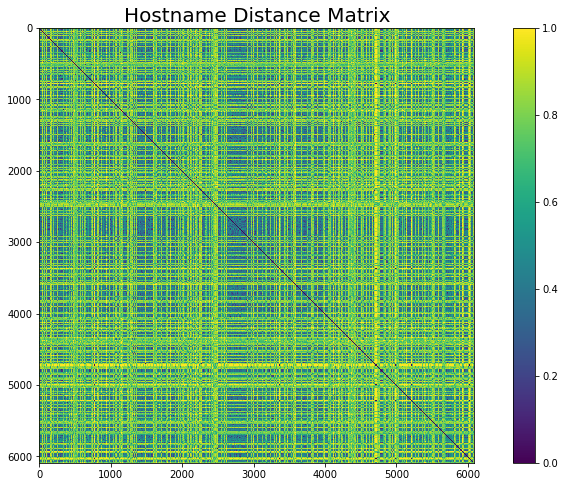

In [7]:
# Examine the Distance Matrix
plt.figure(figsize=(14, 8))
plt.imshow(D)
plt.clim(0, 1)
plt.colorbar()
plt.title('Hostname Distance Matrix', fontsize=20)
plt.show()

# Exercise 1: Query some hostnames from the list, to see what the distances look like. Do they seem to make sense?

#### DBSCAN Parameters

There are two parameters when using DBSCAN:

1. *epsilon* := the maximum distance between two samples for them to be considered as in the same neighborhood
2. *minSamples* := The number of samples (or total weight) in a neighborhood for a point to be considered as a core point (includes the point itself)

These parameters were manually selected.... later on in the notebook, we will take a look at setting the parameters to different values.  If you set *epsilon* too high, you get clusters that are too diverse.  If you set *minSamples* too low, you get small clusters that really should be anomalies.

We may need to change these parameters for different customers.  But they are hopefully not a bad place to start when applying to new data.

Note that DBSCAN returns labels (cluster ids).  Its convention is to have a label of -1 for the anomalous points it was not able to cluster.  Those are the hostnames we want.

In [8]:
# DBSCAN
epsilon = 0.23
min_samples = 5
db = DBSCAN(metric="precomputed", eps=epsilon, min_samples=min_samples).fit(D)

# Indices into data for samples that have clustered
idx_clust = [i for i, clustnum in enumerate(db.labels_) if clustnum > -1]

# Indices into data for samples did not cluster (and are anomalous)
idx_anom = [i for i, clustnum in enumerate(db.labels_) if clustnum == -1]

# Data points that did not get clustered by DBSCAN
data_anom = [data_filt[i] for i in idx_anom]

# Counter of cluster labels
label_ctr = Counter(db.labels_)

print('# samples input to DBSCAN = {}'.format(F))
print('# samples clustered by DBSCAN = {}'.format(len(idx_clust)))
print('# samples not clustered by DBSCAN = {}'.format(len(idx_anom)))
print()
print('# clusters DBSCAN found = {}'.format(len(label_ctr) - 1))
print('DBSCAN cluster number and sizes:')
print('    ', label_ctr)

# samples input to DBSCAN = 6091
# samples clustered by DBSCAN = 4412
# samples not clustered by DBSCAN = 1679

# clusters DBSCAN found = 47
DBSCAN cluster number and sizes:
     Counter({0: 3600, -1: 1679, 3: 233, 13: 46, 5: 44, 4: 38, 2: 34, 9: 34, 1: 27, 14: 21, 30: 21, 22: 20, 29: 17, 19: 16, 28: 15, 38: 15, 6: 12, 12: 11, 20: 11, 26: 11, 41: 11, 36: 10, 37: 10, 7: 9, 11: 9, 17: 9, 35: 9, 39: 8, 40: 8, 21: 7, 23: 7, 27: 7, 32: 6, 42: 6, 15: 5, 46: 5, 8: 5, 10: 5, 16: 5, 18: 5, 24: 5, 25: 5, 33: 5, 31: 5, 34: 5, 45: 5, 43: 5, 44: 5})


In [9]:
# Examine a cluster discovered by the algorithm
clust_num = 1
clust_idx = [i for i, cnum in enumerate(db.labels_) if cnum == clust_num]
print('(User, Hostname) Tuples in Cluster', clust_num)
for i in clust_idx:
    print("    ", data_filt[i])

(User, Hostname) Tuples in Cluster 1
     ('mcgregoa', '02HW12076')
     ('bandyopa', '02HW12118')
     ('atiemoor', '02HW12115')
     ('scottmaj', '02HW12114')
     ('taylom36', '02HW12080')
     ('doyler5', '02HW12126')
     ('haneys1', '02HW12119')
     ('kotoyej', '02HW12125')
     ('dejongb1', '02HW12075')
     ('kingn1', '02HW12077')
     ('sylvesk1', '02HW12113')
     ('jayabas1', '02HW12079')
     ('smithn18', '02HW12123')
     ('kannanp1', '02HW12117')
     ('dcoutok', '02HW12114')
     ('patelp24', '02HW12042')
     ('DEJONGB1', '02HW12075')
     ('rapanosl', '02HW12044')
     ('kohoydaj', '02HW12120')
     ('smithn18', '02HW12043')
     ('harperk', '02HW12074')
     ('scottmaj', '02HW12078')
     ('kroonp', '02HW12039')
     ('stjohnr1', '02HW12116')
     ('sreejas', '02HW12040')
     ('toddywab', '02HW12124')
     ('reinkem', '02HW12121')


#### Reorder the rows/columns in the distance matrix by DBSCAN cluster number

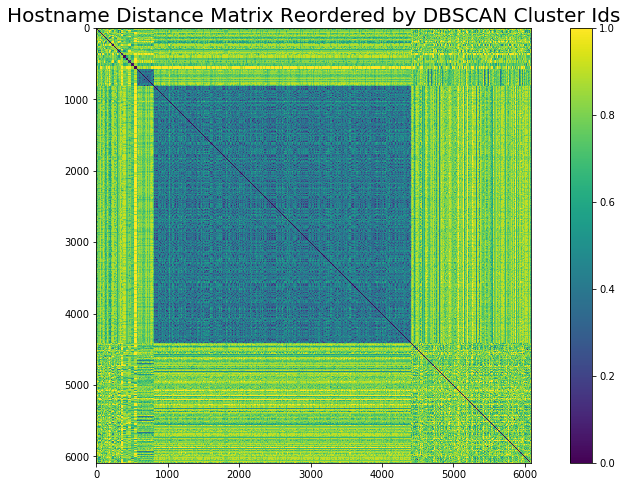

In [10]:
# Reorder the matrix
#  - order by increasing size of the cluster
#  - non-clustered points are last
def sort_by_cluster(labels):
    sorted_label_ctr = Counter(labels).most_common()
    idx = list()
    for i in range(len(sorted_label_ctr)):
        iRev = len(sorted_label_ctr) - 1 - i
        if sorted_label_ctr[iRev][0] != -1:
            clust_idx = [k for k, cnum in enumerate(labels) if cnum == sorted_label_ctr[iRev][0]]
            idx.extend(clust_idx)
    # Handle the non-clustered points last
    clust_idx = [k for k, cnum in enumerate(labels) if cnum == -1]
    idx.extend(clust_idx)
    return idx

# Reorder index
sorted_idx = sort_by_cluster(db.labels_)

# Examine the Distance Matrix
plt.figure(figsize=(14, 8))
plt.imshow(D[sorted_idx,:].take(sorted_idx, axis=1))
plt.clim(0, 1)
plt.colorbar()
plt.title('Hostname Distance Matrix Reordered by DBSCAN Cluster Ids', fontsize=20)
plt.show()

In [11]:
# Look at a few random samples from the big cluster
if label_ctr.most_common()[0][0] == -1:
    # if largest cluster are the outliers, then use 2nd largest cluster
    clust_num = label_ctr.most_common()[1][0]
else:
    clust_num = label_ctr.most_common()[0][0]

clust_idx = [i for i, cnum in enumerate(db.labels_) if cnum == clust_num]
print("Some of the User,Hostname Tuples in the Largest Cluster", clust_num)
for i in range(50):
    print("    ", data_filt[clust_idx[i]])

Some of the User,Hostname Tuples in the Largest Cluster 0
     ('johnmm', 'CMPLTSD0500FDZ')
     ('middendi', 'CMPLTSD0291FBM')
     ('donaldrs', 'CMPLTSU1373DXP')
     ('searleb', 'CMPLTCD04516NV')
     ('markpo', 'CMPLTSD1131L93')
     ('sulemann', 'CMPLTSD0451498')
     ('kadam', 'CMPLTSD1131JSW')
     ('chutt', 'CMPLTSD1131G0W')
     ('mli', 'CMPLTSD1152G6L')
     ('tjohnson', 'CMPLTSD1152901')
     ('aobaid', 'CMPLTSD11314VN')
     ('cflowers', 'CMPLTOD0500CMY')
     ('burtonk', 'CMPLTSD115299D')
     ('esmillaf', 'CMPLTSU1400Q8Q')
     ('gillianf', 'CMPLTSD1152C3G')
     ('rain1', 'CMPLTSD1131DCN')
     ('villalon', 'CMPLTSU1400K8F')
     ('mastranm', 'CMPLTSD0240QRV')
     ('herk', 'CMPLTVD0501LV9')
     ('veerak', 'CMPLTSD1152FC4')
     ('charleab', 'CMPLTSD0351TWP')
     ('massettj', 'CMPLTSD1245PH1')
     ('aleecel', 'CMPLTSD11529B6')
     ('muralikp', 'CMPLTSD0230HBT')
     ('naraja', 'CMPLTSD1131G1Q')
     ('jasoeder', 'CMPLTOD0500CHB')
     ('grattonr', 'CMPLTCD045154J')
 

#### Hyperparameter Optimization

To set *epsilon* and *minSamples*, we can do a grid search over a portion of parameter space.  After doing this, you visually and manually go through the clusters to get a feel for the best setting on this dataset.

Our main criteria for setting *epsilon* ended up being:
- How many of the hostnames that begin with `COM` did not get put into a cluster?  If it seemed like too many of these data points were not getting clustered, then I thought *epsilon* was too small (e.g., the distance criteria for being a cluster was too strict).
- Were there individual clusters that had hostnames that seemed too diverse?  This would occur if you set *epsilon* too large.  For example, sometimes you would get a cluster that contained the hostnames `'JONATHAN-LEFFLERs-MacBook-Pro'` and `'Joseph-PC'`.  That seemed too diverse of a cluster.

For setting *minSamples*:
- Looking at the very small clusters, did they seem like hostnames that we would want to filter out, or did they seem like hostnames you would want to be deemed non-standard?

In [12]:
# Conduct a grid search (gs) over DBSCAN Parameters
gs_epsilon = (0.1, 0.2, 0.3)    # smaller numbers give you tighter clusters
gs_min_samples = (15, 10, 5)    # smaller numbers means you need less evidence to create a cluster
gs_db = list()

print("#, epsilon, min_samples, num_clusters, num_non_standard")
cnt = 0
for e in gs_epsilon:
    for ms in gs_min_samples:
        db_cnt = DBSCAN(metric="precomputed", eps=e, min_samples=ms).fit(D)
        ctr_cnt = Counter(db_cnt.labels_)
        print(cnt, ",", e, ",", ms, ",", len(ctr_cnt), ",", ctr_cnt[-1])
        gs_db.append((e, ms, db_cnt))
        cnt += 1

#, epsilon, min_samples, num_clusters, num_non_standard
0 , 0.1 , 15 , 17 , 4213
1 , 0.1 , 10 , 25 , 3641
2 , 0.1 , 5 , 53 , 2878
3 , 0.2 , 15 , 15 , 2128
4 , 0.2 , 10 , 21 , 2017
5 , 0.2 , 5 , 42 , 1821
6 , 0.3 , 15 , 19 , 1666
7 , 0.3 , 10 , 26 , 1478
8 , 0.3 , 5 , 38 , 1245


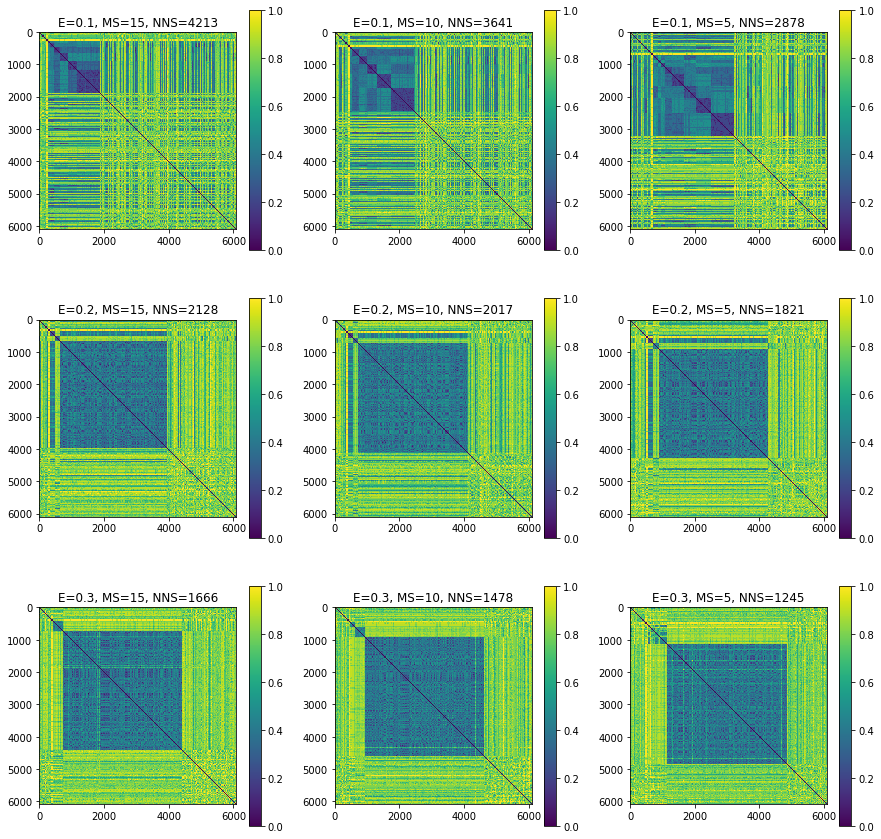

In [249]:
# Plot the Matrix Reorderings
cnt = 0
for i in range(len(gs_epsilon)):
    for j in range(len(gs_min_samples)):
        # Sort the Indices by Cluster
        sorted_idx = sort_by_cluster(gs_db[cnt][2].labels_)
        # Plot
        plt.subplot(len(gs_epsilon), len(gs_min_samples), cnt+1)
        plt.imshow(D[sorted_idx,:].take(sorted_idx, axis=1))
        plt.clim(0,1)
        plt.colorbar()
        # Title contains epsilon (E), min_samples (MS), num_non_standard (NNS)
        plt.title("E="+str(gs_epsilon[i])+", MS="+str(gs_min_samples[j])+", NNS="+str(Counter(gs_db[cnt][2].labels_)[-1]))
        # Increment Subplot
        cnt += 1

fig = plt.gcf()
fig.set_size_inches(15,15)
plt.show()

### Exercise 2:  try a grid search with different ranges for eps and min_samples, then plot the results. Bonus: Track how long it takes to perform the grid search.

#### K-Nearest Neighbor Distance for each Sample

One way to try to set *epsilon* is to look at the k-nearest neighbor plot.

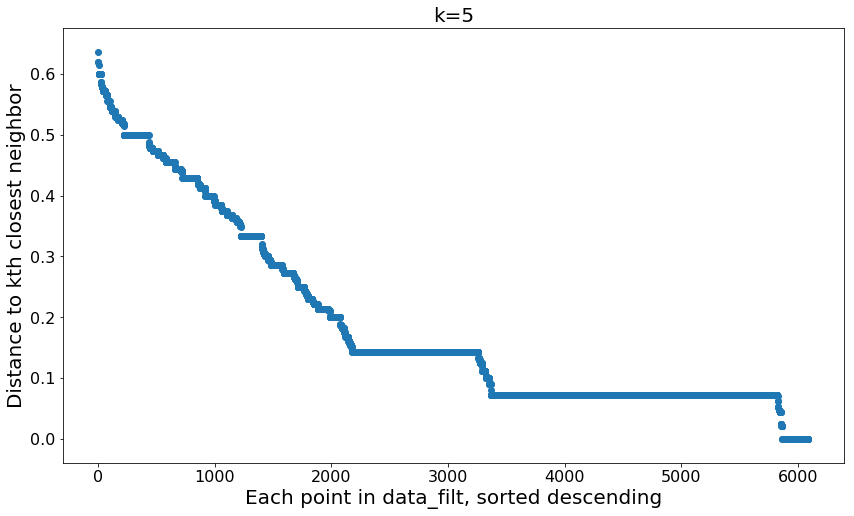

In [13]:
# Find nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples, algorithm='auto', metric='precomputed').fit(D)
knn_dist, knn_idx = nn.kneighbors(D)

# Plot sorted distance to the k-th point
sorted_k_dist = sorted([x[min_samples-1] for x in knn_dist], key=lambda y: -y)

plt.figure(figsize=(14, 8))
plt.scatter(range(len(knn_dist)),sorted_k_dist)
plt.ylabel('Distance to kth closest neighbor', fontsize=20)
plt.xlabel('Each point in data_filt, sorted descending', fontsize=20)
plt.title('k='+str(nn.n_neighbors), fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

#### Silhouette Analysis

In [14]:
# Compute silhouette score for each element in the grid search
gs_metrics = list()
for (e, ms, db_cnt) in gs_db:
    ss = metrics.silhouette_score(D, db_cnt.labels_)
    gs_metrics.append(ss)
    print('eps =', e, ', min_samples =', ms, ', silhouette score =', ss)

eps = 0.1 , min_samples = 15 , silhouette score = -0.2905930964008356
eps = 0.1 , min_samples = 10 , silhouette score = -0.2086966605131688
eps = 0.1 , min_samples = 5 , silhouette score = -0.1031790848597786
eps = 0.2 , min_samples = 15 , silhouette score = -0.07675592987673355
eps = 0.2 , min_samples = 10 , silhouette score = -0.05451779486997196
eps = 0.2 , min_samples = 5 , silhouette score = -0.058217763634238986
eps = 0.3 , min_samples = 15 , silhouette score = 0.3179344986457877
eps = 0.3 , min_samples = 10 , silhouette score = 0.31201805684114037
eps = 0.3 , min_samples = 5 , silhouette score = 0.29701475728057664


### Exercise: Try plotting different Ks and see what min_sample + epsilon combinations might work, then calculate the silhouette score for your parameters

#### Visualize 2d embeddings of the clusters

http://scikit-learn.org/stable/modules/manifold.html

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

In [15]:
# 2d unsupervised embeddings
embed_tsne = manifold.TSNE(n_components=2, metric="precomputed", n_iter=1000)
#embed_mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
#embed_se = manifold.SpectralEmbedding(n_components=2, affinity="precomputed")

# Fit the Embeddings
D_tsne = embed_tsne.fit_transform(D)
#D_mds = embed_mds.fit_transform(D)       # this one is slow...
#D_se = embed_se.fit_transform(1.0 - D)   # wants an affinity matrix instead of a distance matrix

In [16]:
# Assumes labels is from DBSCAN, so labels value of -1 means it is from the non-clustered group
def plot_clusters_plotly(embeddings, labels, names):
    # Unique Labels
    uniq_labels = sorted(list(set(labels)))

    # Traces for each cluster
    trace_list = list()
    for label in uniq_labels:
        # Marker Symbol and Size for Clustered vs Non-Clustered Points
        # Symbol Options = circle, square, diamond, cross, x, triangle-up, pentagon, hexagon, star, star-diamond, 
        if label == -1:
            marker_size = 5
            marker_symbol = 'square'
        else:
            marker_size = 6
            marker_symbol = 'circle'
            
        # See Colorscales here:
        # https://plot.ly/ipython-notebooks/color-scales/

        # Trace
        cluster_trace = Scatter(
            x = [embeddings[i,0] for i,label_i in enumerate(labels) if label_i==label],
            y = [embeddings[i,1] for i,label_i in enumerate(labels) if label_i==label],
            text = [names[i][1] for i,label_i in enumerate(labels) if label_i==label],
            mode = 'markers',
            hoverinfo = 'text',
            marker = Marker(size=marker_size, symbol=marker_symbol, color=label, colorscale='RdYlBu'),
            name = label
        )
        
        # Append Result
        trace_list.append(cluster_trace)
    
    # Make the Plot
    plotly.offline.iplot({"data":Data(trace_list),
                          "layout":Layout(
                              title="Hostname Embeddings",
                              titlefont=dict(size=16),
                              showlegend=False, 
                              width=975,
                              height=650,
                              hovermode='closest',
                              annotations=[ dict(
                                  showarrow=False,
                                  text="",
                                  xref="paper", yref="paper",
                                  x=0.005, y=-0.002 ) ],
                              xaxis=XAxis(showgrid=True, zeroline=False, showticklabels=False),
                              yaxis=YAxis(showgrid=True, zeroline=False, showticklabels=False))})
    return()

In [17]:
plot_clusters_plotly(D_tsne, db.labels_, data_filt)

()

### Exercise: As an alternative to DBSCAN, try a different anomaly detection algorithm like Local Outlier Factor (LOF).

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

***

# Results

Let's look at our most anomalous `(user, hostname)` tuples.  In reality, we could order/rank them using other information in the VPN logs... or perhaps by combining the output of multiple anomaly detectors.

For DBSCAN, we can use the nearest neighbor distance for our anomalous samples to create an order.

For LOF, we can use the LOF score itself to create an ordering.

In [18]:
# Find nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples, algorithm='auto', metric='precomputed').fit(D)
knn_dist, knn_idx = nn.kneighbors(D)

# Look at distance to the k-th neighbor for samples deemed anomalous by DBSCAN, then
# show the top 100 in the list
results = {}
for tup, kdist, clust_num in zip(data_filt, knn_dist, db.labels_):
    if clust_num == -1:
        results[tup] = kdist[min_samples - 1]   # distance to the k-th neighbor
#        results[tup] = kdist[1]                 # distance to nearest neighbor
        
# Show top 100 most anomalous (user, hostname)
cnt = 0
for tup, kdist in sorted(results.items(), key=lambda y: -y[1]):
    print(tup)
    cnt += 1
    if cnt >= 100:
        break

('dans2', 'DBx')
('kchellak', 'VIJI-7E93C07BCB')
('timothpa', 'FM-F542B687EDBA')
('vandanac', 'ww7204643wxpr')
('sam', 'lhqlv7hk4q')
('rama1', 'shuji-22ff43ae4')
('dmubashi', 'q-l1oz8ckm0s9rc')
('tylerf', 'TFIZZ')
('vquan', '8RG5811')
('thiagarr', 'MW7CIDZJ47GCXL')
('jonatmwo', 'J.local')
('chewt', 'SG3-L9WKJ5R1')
('debiek', '6qtt431')
('kamplind', '5ZDMHD1')
('jamesamo', 'FW590')
('jyoung', 'FH8321-JerryCellilo.local')
('torres', 'GWL')
('monroed3', 'VS6')
('KyleA', 'E06423KABBEY7X')
('mcarthui', 'N5')
('kmattox', 'brady-38f88e984')
('oliverid', 'VU34933')
('hopsona2', 'W5599')
('rinderkc', 'pvv-pvv')
('mummertm', 'IOMLKFB72KTM1L')
('renisonm', 's1i008.urbangrind.ptp')
('generon', 'n-a482af32b48a4')
('ancoffey', 'A25BD8260D5F438')
('miketu', 'cc2dffc725')
('davidzh', 'BIOG-DZHANGX220')
('pitruzzm', 'D8G8KS91')
('kangc1', 'BUDU-9TG8LQ1')
('dynekj', 'SFOMJD7862.local')
('voggumuk', 'MW7EYGXFFSNL1E')
('chebonda', 'D4RHYV61')
('cabad', 'xlonelyxbluex.local')
('acordrey', 'Queen-Bee-89.loc

### Did this process identify known attacker activity?

### Looking at these results, do you have ideas on ways the process might be improved?